# Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import anvil.server
import anvil.media

In [ ]:
img_height = 512
img_width = 512

# Generator and Discriminator

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [ ]:
def downsample(filters, size, norm_type = 'batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    else:
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, norm_type = 'batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def unet_generator(output_channels, norm_type = 'batchnorm'):

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),
      downsample(128, 4, norm_type),
      downsample(256, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type),
      downsample(512, 4, norm_type)
  ]

  up_sample = [
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type, apply_dropout=True),
      upsample(512, 4, norm_type),
      upsample(256, 4, norm_type),
      upsample(128, 4, norm_type),
      upsample(64, 4, norm_type)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])
  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_sample, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
def discriminator(norm_type = 'batchnorm'):
  initializer = tf.random_normal_initializer(0.,0.02)

  inp = tf.keras.layers.Input(shape=[img_height, img_width, 3], name = 'input_image')
  x = inp

  down1 = downsample(64, 4, norm_type, False)(x)
  down2 = downsample(128, 4, norm_type)(down1)
  down3 = downsample(256, 4, norm_type)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
output_channels = 3
generator_g = unet_generator(output_channels, norm_type = 'instancenorm')
# generator_f = unet_generator(output_channels, norm_type = 'instancenorm')
# discriminator_x = discriminator(norm_type = 'instancenorm')
# discriminator_y = discriminator(norm_type = 'instancenorm')

In [ ]:
generator_g.summary()

# Model loading and parameters

In [ ]:
input_size = (img_height,img_width)
input_shape = (img_height,img_width,3)

In [ ]:
#Connection to GDRIVE for loading the saved model
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
generator_g.load_weights('/content/drive/MyDrive/Project CycleGan/model_cyclegan.weights.h5')  # Path to the uploaded file

# Generate images

In [ ]:
def generate_image(model, test_input):
  generated = model(test_input)
  generated = tf.squeeze(generated, axis=0)
  generated = np.clip(generated, 0, 1)
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))
  ax.axis('off')
  fig.tight_layout(pad=0)
  # To remove the huge white borders
  ax.margins(0)
  ax.imshow(generated);
  plt.savefig('my_plot.png', dpi=300)

# Anvil Connection

In [ ]:
# @anvil.server.callable
# def show_image(file):
#   with anvil.media.TempFile(file) as f:
#     image = tf.keras.utils.load_img(f)

#   image = image.resize(input_shape)

#   image = tf.keras.preprocessing.image.img_to_array(image)
#   image = tf.expand_dims(image, 0)

#   generate_image(generator_g, image)

#   image = anvil.media.from_file("my_plot.png")

#   return image

In [ ]:
!pip install Pillow

from PIL import Image

@anvil.server.callable
def show_image(file):
  with anvil.media.TempFile(file) as f:
    # Load the image using PIL instead of tf.keras.utils.load_img
    image = Image.open(f)

  # Resize the image using Pillow
  # Pass the desired size as a tuple (width, height)
  image = image.resize((img_height, img_width))

  # Convert to a format compatible with your generator
  image = tf.keras.preprocessing.image.img_to_array(image)

  image = image/255

  image = tf.expand_dims(image, 0)  # Add batch dimension

  generate_image(generator_g, image)

  image = anvil.media.from_file("my_plot.png")

  return image

In [ ]:
#dog predictor 1
anvil.server.connect("server_ZOPN2GJCLCXO44WTM4QHZHLE-LKLM6LJNPFGXAFTF")

In [ ]:
#anvil.server.wait_forever()

# **בדיקה**

In [ ]:
import os

In [ ]:
!kaggle datasets download heonh0/daynight-cityview

Dataset URL: https://www.kaggle.com/datasets/heonh0/daynight-cityview
License(s): CC0-1.0
 99% 493M/499M [00:07<00:00, 69.1MB/s]
100% 499M/499M [00:07<00:00, 73.6MB/s]


In [ ]:
!unzip -oq daynight-cityview.zip

In [ ]:
day_dir = '/content/day'
night_dir = '/content/night'

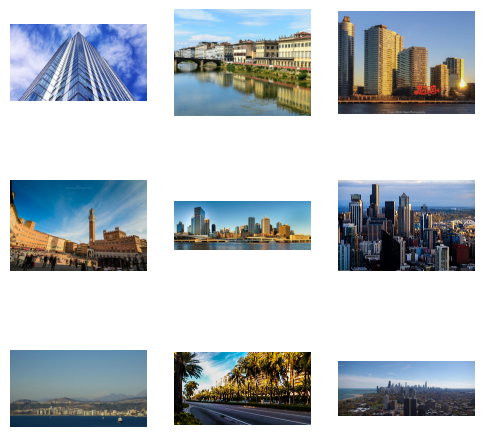

In [ ]:
plt.figure(figsize=(6, 6))
for i, filename in enumerate(os.listdir(day_dir)):
    if i == 9:
        break

    # Construct the full image path
    img_path = os.path.join(day_dir, filename)

    # Open and display the image using PIL
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
image_paths = tf.io.gfile.glob(os.path.join(day_dir, '*.jpg'))
image_paths = [path for path in image_paths if tf.io.gfile.exists(path)]

day_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def load_image(image_path):
  image_path = tf.py_function(lambda x: x.numpy().decode('utf-8'), [image_path], tf.string)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_width, img_height])
  #return image, image_path
  return image

day_dataset = day_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
day_dataset=day_dataset.batch(1)

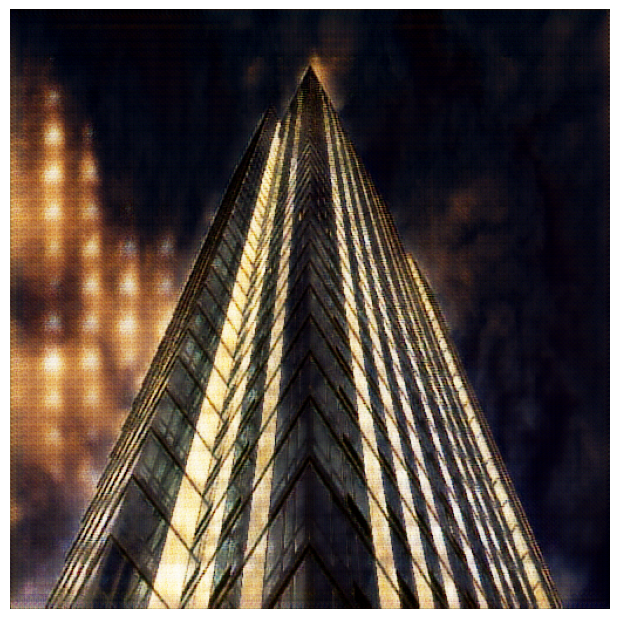

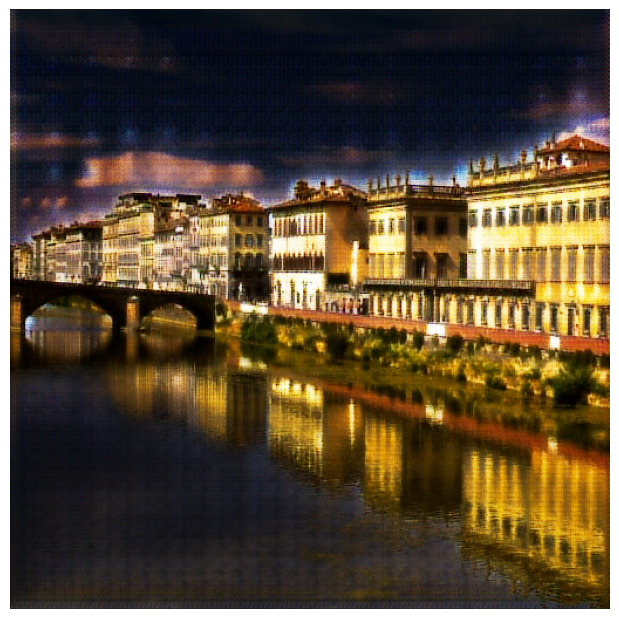

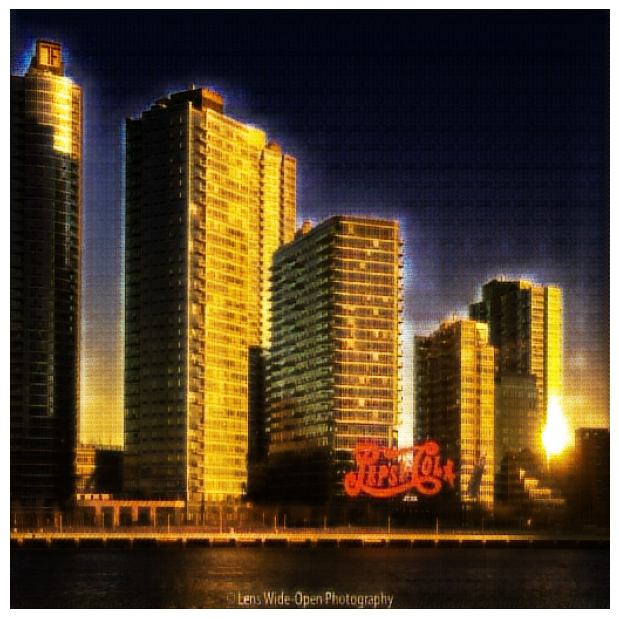

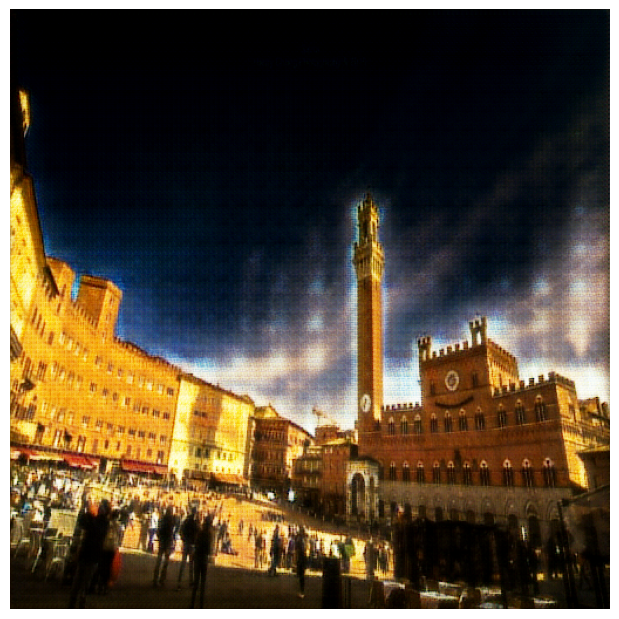

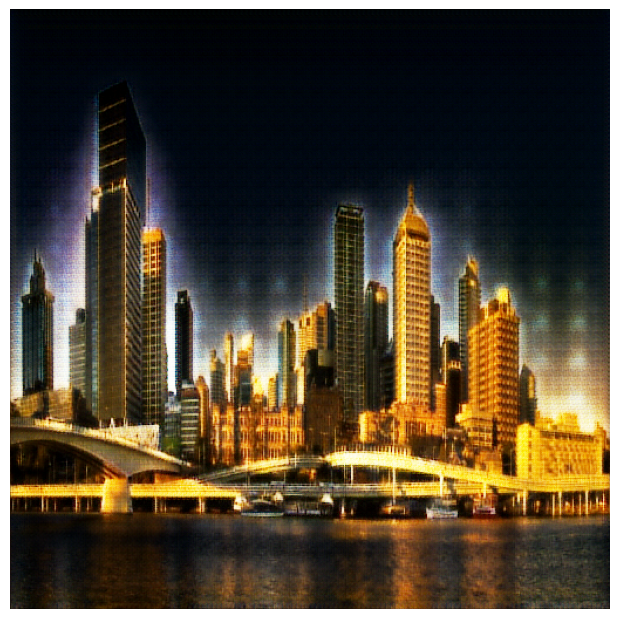

In [ ]:
for input in day_dataset.take(5):
  #print(input)
  #input = tf.squeeze(input)
  x = generate_image(generator_g, input)